Here's a toy demo for the following paper... 
- Lu, Q., Chen, P.-H., Pillow, J. W., Ramadge, P. J., Norman, K. A., & Hasson, U. (2018). 
Shared Representational Geometry Across Neural Networks. arXiv [cs.LG]. 
Retrieved from http://arxiv.org/abs/1811.11684

Here's the <a href="https://github.com/qihongl/nnsrm-neurips18">repo</a> for that project. 

In [1]:
import torch
import numpy as np
from data_gen import get_XOR_data
from models import Net, train_net, get_hidden_acts
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white', context='talk', palette='colorblind')

np.random.seed(0)
torch.manual_seed(0)
%autosave 5 

# some simulation params
n_epochs = 500
learning_rate = .003
n_hidden = 50
n_features = 2
n_pts_each_cloud = 50

Autosaving every 5 seconds


First of all, we need generate some learning problem to train a neural network. In this notebook, we train the network on a noisy XOR task. The figure below shows the training set, the test set is independently generated. 

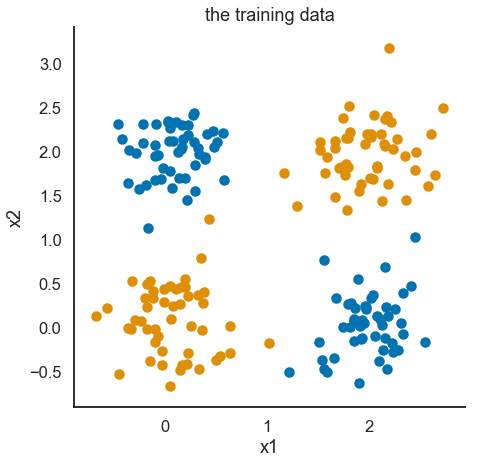

In [2]:
# generate some XOR data
x, y = get_XOR_data(n_pts_each_cloud)
x_test, y_test = get_XOR_data(n_pts_each_cloud)
n_examples = len(y)

# plot the data 
cur_palette = sns.color_palette(n_colors=2)

f, ax = plt.subplots(1,1, figsize=(7,7))
for i, y_val in enumerate(np.unique(y.numpy())): 
    ax.scatter(
        x.numpy()[y_val == y.numpy(),0],x.numpy()[y_val == y.numpy(),1], 
        color=cur_palette[i]
    )    
ax.set_xlabel('x1')    
ax.set_ylabel('x2')
ax.set_title('the training data')
sns.despine()

Now we define a simple neural network. 

In [3]:
# define two networks
n_nets = 2
loss_func = torch.nn.MSELoss()

net1 = Net(n_feature=n_features, n_hidden=n_hidden, n_output=1)
optimizer1 = torch.optim.Adam(net1.parameters(), lr=learning_rate)
net1, accuracy_train_1, accuracy_test_1 = train_net(
    net1, loss_func, optimizer1, 
    n_epochs, x, y, x_test, y_test
)

net2 = Net(n_feature=n_features, n_hidden=n_hidden, n_output=1)
optimizer2 = torch.optim.Adam(net2.parameters(), lr=learning_rate)

net2, accuracy_train_2, accuracy_test_2 = train_net(
    net2, loss_func, optimizer2, 
    n_epochs, x, y, x_test, y_test
)

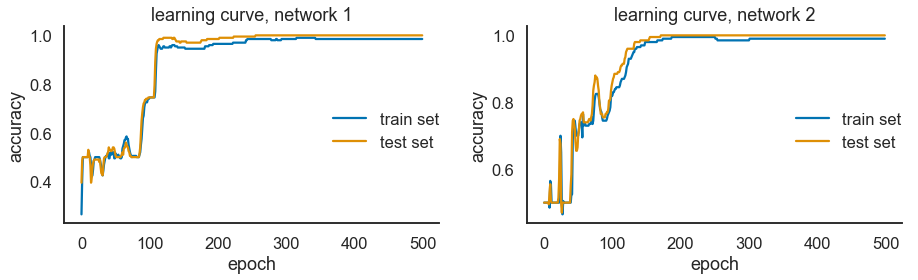

In [4]:
accs_train = [accuracy_train_1, accuracy_train_2]
accs_test = [accuracy_test_1, accuracy_test_2]

# plot the learning curve 
f, axes = plt.subplots(1,2, figsize=(13,4))
for i, ax in enumerate(axes): 
    
    ax.plot(accs_train[i], label='train set')
    ax.plot(accs_test[i], label='test set')
    ax.set_title(f'learning curve, network {i+1}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.legend(frameon=False, bbox_to_anchor=(.7, .6), loc=2, borderaxespad=0)
    
sns.despine()
f.tight_layout()

#### observation: "representational similarity matrix" are similar across networks


The following figure compare the similarity between ... 
- the evoked response of stimulus i in one network 
- the evoked response of stimulus j in **the same** network 

The result shows that the two networks learn basically the same "representational similarity". That is, the relation between stimulus i and stimulus j is similar across the two networks. 

In [5]:
# test the network and get its hidden layer activity 
h1 = get_hidden_acts(net1, x_test).T
h2 = get_hidden_acts(net2, x_test).T
hidden_act_mats = [h1, h2]

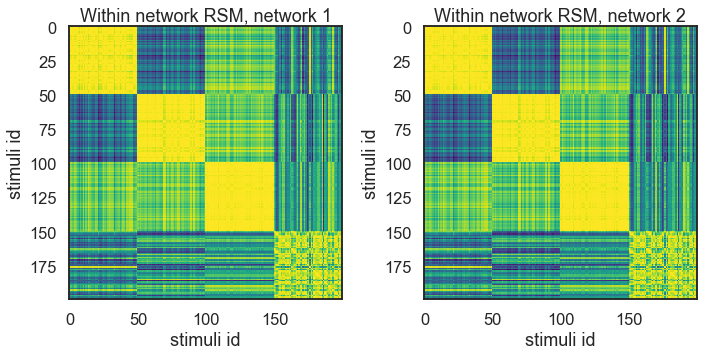

In [6]:
f,axes = plt.subplots(1, 2, figsize=(10,5))

for i, h_i in enumerate(hidden_act_mats):
    axes[i].imshow(np.corrcoef(h_i.T), cmap='viridis')
    axes[i].set_xlabel('stimuli id')
    axes[i].set_ylabel('stimuli id')
    axes[i].set_title(f'Within network RSM, network {i+1}')
f.tight_layout()

#### BUT: the same stimulus evoke different response patterns across the two networks

The following figure compare ... 
- evoked hidden activity pattern of stimulus i from one network 
- evoked hidden activity pattern of stimulus j from **another** network 

You can see that the following matrix doesn't reflect the consistent representational similarity structure at all :( 

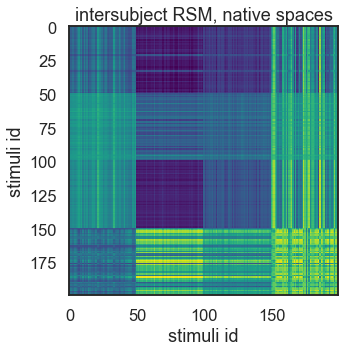

In [7]:
inter_subject_RSM = np.corrcoef(h1.T,h2.T)[:n_examples,n_examples:]

f, ax = plt.subplots(1, 1, figsize=(6,5))

ax.imshow(inter_subject_RSM, cmap='viridis')
ax.set_xlabel('stimuli id')
ax.set_ylabel('stimuli id')
ax.set_title('intersubject RSM, native spaces')
f.tight_layout()

**But why is this the case?** What's similar across these two networks? How do these two networks encode the same similarity structure with different patterns of neural activity? 

We observed that the main reason is that they are misaligned. They have similar RSMs, which means their representational structure have the same "shape", and they can be aligned with rigid-body-transformations. 

In the two subject case, we can solve the optimal orthogonal transformation by solving the procrustes problem. However, in the more general case of aligning n networks, we need the shared response model. 

#### how to run the shared response model

The following code blocks provide a minimal example of the SRM alignment pipeline. 

*In practice, the number of components for SRM can be tuned like how you tune PCA (e.g. measure variance explained). 

In [8]:
from brainiak.funcalign.srm import SRM
from sklearn.preprocessing import StandardScaler

In [9]:
# step 1
# get neural network activity matrices ... 
h1_train = get_hidden_acts(net1, x).T
h2_train = get_hidden_acts(net2, x).T
h1_test = get_hidden_acts(net1, x_test).T
h2_test = get_hidden_acts(net2, x_test).T

In [10]:
# step 2 normalize the data 
ss = StandardScaler()

ss.fit(h1_train)
h1_train = ss.transform(h1_train)
h1_test = ss.transform(h1_test)

ss.fit(h2_train)
h2_train = ss.transform(h2_train)
h2_test = ss.transform(h2_test)

In [11]:
# step 3
# define the SRM object 
n_components = 20
srm = SRM(features=n_components)

# train SRM on the training set 
h_train = [h1_train, h2_train]
h_train_shared = srm.fit_transform(h_train)

# use the trained SRM to transform the test set activity
h_test = [h1_test, h2_test]
h_test_shared = srm.transform(h_test)

Once aligned, the intersubject RSM is become similar to the within-subject RSM. 

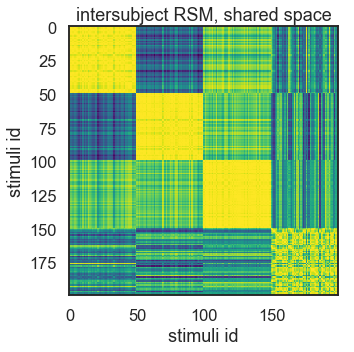

In [12]:
# compute inter-subject RSM in for the transformed activities (in the shared space)
inter_subject_RSM_shared = np.corrcoef(
    h_test_shared[0].T,h_test_shared[1].T
)[:n_examples,n_examples:]

f, ax = plt.subplots(1, 1, figsize=(6,5))

ax.imshow(inter_subject_RSM_shared, cmap='viridis')
ax.set_xlabel('stimuli id')
ax.set_ylabel('stimuli id')
ax.set_title('intersubject RSM, shared space')
f.tight_layout()

Visualize the aligned response trajectories in the shared space. 

In [13]:
import hypertools as hyp

Sometimes you need to run the following 2 blocks twice to show the animation. I still haven't figure out what's going on here ... 

In [16]:
%matplotlib notebook 

Traceback (most recent call last):
  File "/Users/Qihong/anaconda/envs/brainiak/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/Users/Qihong/anaconda/envs/brainiak/lib/python3.6/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


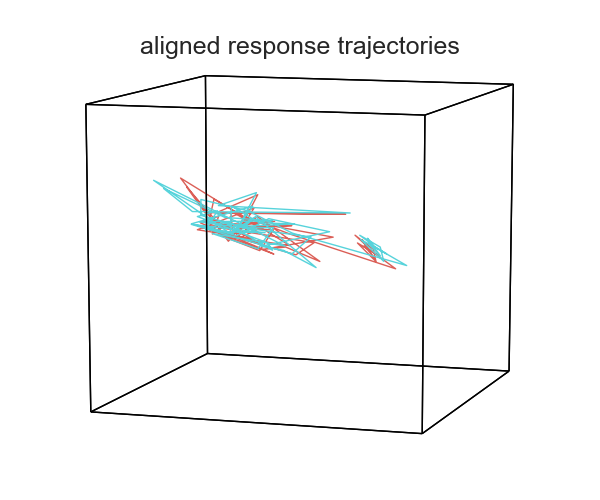

In [17]:
# re-orient the data for plotting
h_test_shared_T = [h_test_shared[s].T for s in range(n_nets)]

hyp.plot(
    h_test_shared_T, 
    animate=True, 
    tail_duration = 1, frame_rate=60, rotations=.05, 
    title = "aligned response trajectories", 
    size = (6, 5)
)


### Thank you very much to your time!